# Check the GWAS results

## Before LD correction

Let's read in the raw GWAS results filter, associations with a p<1e-5 and create an overview.

In [127]:
import warnings

warnings.simplefilter("ignore")

In [128]:
import pandas as pd
from rich.progress import track
from glob import glob
from os.path import basename

files = glob("data/gwas_filtered/*.tsv.gz")
final = []
for fi in track(files):
    try:
        gwas = pd.read_csv(fi, sep="\t")
    except pd.errors.EmptyDataError:
        continue
    if not "P" in gwas.columns:
        continue
    gwas["metabolite"] = basename(fi).split(".tsv")[0].replace("filtered_", "")
    final.append(gwas)
final = pd.concat(final)

Output()

In [129]:
final

,CHR,SNP,POS,A1,A2,N,AF1,BETA,SE,P,metabolite
0,15,rs147955703,41918035,A,G,1000,0.0060,-0.620888,0.136803,5.664420e-06,metabolite_100000997
1,15,rs146819334,55834900,A,G,1000,0.0130,-0.465256,0.093412,6.336560e-07,metabolite_100000997
2,16,rs142656671,6406759,A,G,1000,0.0180,0.354406,0.079999,9.417340e-06,metabolite_100000997
3,16,rs75446625,77757141,G,C,1000,0.0615,0.195718,0.043393,6.470670e-06,metabolite_100000997
4,16,rs160197,77760157,C,T,1000,0.7135,-0.120304,0.023057,1.812160e-07,metabolite_100000997
...,...,...,...,...,...,...,...,...,...,...,...
106,8,rs149090860,66714393,C,T,1000,0.0105,-0.525166,0.116832,6.954760e-06,metabolite_999952843
107,8,rs72652802,67681938,G,A,1000,0.1260,-0.171996,0.035294,1.098040e-06,metabolite_999952843
108,8,rs72654908,67745874,T,C,1000,0.1140,-0.176016,0.036679,1.595610e-06,metabolite_999952843
109,9,rs10965499,22889446,T,G,1000,0.4165,-0.112291,0.023932,2.703530e-06,metabolite_999952843


In [130]:
max_pos = pd.read_csv("data/grch37_chr.tsv", index_col=0, sep="\t", header=None).iloc[:, 0]
max_pos[0] = 0
max_pos.sort_index(inplace=True)

In [131]:
final["absolute_position"] = final.POS + max_pos.sort_index().cumsum()[final.CHR - 1].values
final = final.sort_values(by=["CHR", "POS"]).reset_index(drop=True)

In [132]:
import numpy as np

final["neg_log_p"] = - np.log10(final.P) 

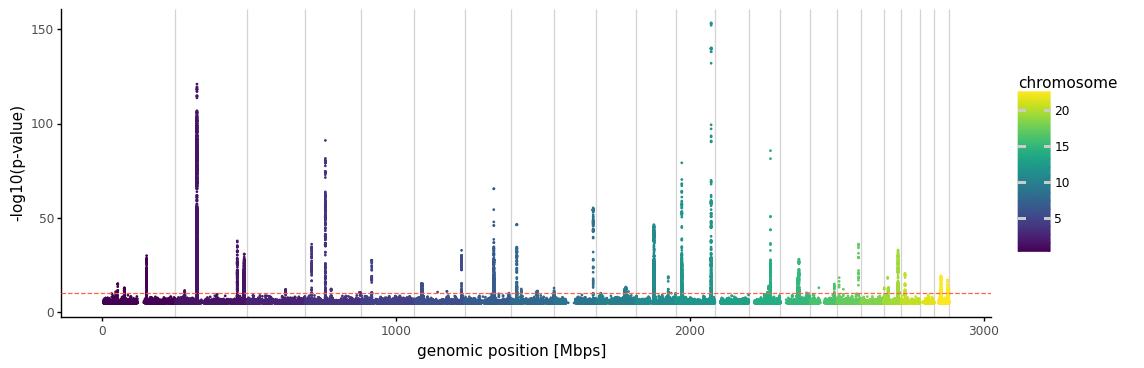

<ggplot: (8725886953915)>

In [156]:
from plotnine import *
theme_set(theme_classic())

stripes = pd.Series(index=final.CHR.unique())
stripes[stripes.index] = "darkblue"
stripes[stripes.index % 2 == 0] = "lightblue"

chr_anns = pd.DataFrame({"x": max_pos.cumsum() / 1e6, "y": 100, "label": max_pos.index})

mh = (
    ggplot(final) + 
    geom_vline(xintercept=chr_anns.x, color="lightgray") +
    aes(x="absolute_position / 1e6", y="neg_log_p", color="CHR") +  
    geom_point(size=0.1) + 
    geom_hline(yintercept=-np.log10(5.29e-11), linetype="dashed", color="tomato") +
    theme(figure_size=(12, 4)) +
    labs(x = "genomic position [Mbps]", y="-log10(p-value)", color="chromosome")
)
mh.save("figures/figS1.png", width=12, height=4, dpi=300)
mh

In [134]:
final

,CHR,SNP,POS,A1,A2,N,AF1,BETA,SE,P,metabolite,absolute_position,neg_log_p
0,1,rs149168804,828539,T,A,1000,0.0195,0.344557,0.075560,0.000005,metabolite_100001856,828539,5.291215
1,1,rs143299207,1057989,T,G,1000,0.0110,-0.210331,0.047227,0.000008,metabolite_100008915,1057989,5.073465
2,1,rs143299207,1057989,T,G,1000,0.0110,-0.312722,0.069828,0.000008,metabolite_100015791,1057989,5.123915
3,1,rs116679929,1232299,T,G,1000,0.0135,0.387749,0.080832,0.000002,metabolite_100021918,1232299,5.792993
4,1,rs192694927,1266475,T,C,1000,0.0145,0.366829,0.078111,0.000003,metabolite_100021918,1266475,5.576723
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102681,22,rs7284429,51033840,G,C,1000,0.5405,-0.037550,0.007937,0.000002,metabolite_100001446,2880762560,5.651063
102682,22,rs131744,51034177,A,G,1000,0.6510,-0.036511,0.008056,0.000006,metabolite_100001446,2880762897,5.233293
102683,22,rs131743,51034867,C,T,1000,0.6535,-0.039240,0.008079,0.000001,metabolite_100001446,2880763587,5.924420
102684,22,rs131741,51034961,T,C,1000,0.6570,-0.039035,0.008109,0.000001,metabolite_100001446,2880763681,5.829718


In [135]:
final.reset_index(drop=True, inplace=True)

## After LD correction

Now we will read in the data set as it is used in the rest of the study.

In [152]:
from utils import rsid2gene
import arivale_data_interface as adi

metabolite_meta = adi.get_snapshot("metabolomics_metadata", clean=True) [["CHEMICAL_ID", "BIOCHEMICAL_NAME", "SUPER_PATHWAY", "SUB_PATHWAY", "CAS", "KEGG"]]
metabolite_meta["metabolite"] = "metabolite_" + metabolite_meta.CHEMICAL_ID.astype(str)

sig_snps = pd.read_csv("data/final_results.csv")
sig_snps["rsid"] = sig_snps.SNP.str.split(";").str[0]
genes = rsid2gene(sig_snps.rsid.unique())
sig_snps = sig_snps.merge(genes, left_on="rsid", right_on="snp", how="left")
sig_snps = sig_snps.merge(metabolite_meta, on="metabolite", how="left")
sig_snps.sort_values(by=["CHR", "BP"]).to_csv("data/gwas_results_annotated.csv", index=False)
sig_snps

,CHR,F,SNP,BP,P,TOTAL,NSIG,S05,S01,S001,...,genes,clinical,chromosome,function_class,CHEMICAL_ID,BIOCHEMICAL_NAME,SUPER_PATHWAY,SUB_PATHWAY,CAS,KEGG
0,1,1,rs61825638,241713402,3.500000e-12,0,0,0,0,0,...,KMO,,1,"intron_variant,splice_donor_variant",98,kynurenate,Amino Acid,Tryptophan Metabolism,492-27-3,C01717
1,3,1,rs4429671,124471899,2.700000e-29,14,0,0,0,0,...,NaN,NaN,NaN,NaN,445,orotate,Nucleotide,"Pyrimidine Metabolism, Orotate containing",50887-69-9,C00295
2,3,1,rs9289238,124573989,1.620000e-13,2,0,0,0,0,...,ITGB5,,3,intron_variant,445,orotate,Nucleotide,"Pyrimidine Metabolism, Orotate containing",50887-69-9,C00295
3,11,1,rs174594,61619829,4.550000e-14,2,0,0,0,0,...,FADS2,,11,intron_variant,229,arachidonate (20:4n6),Lipid,Polyunsaturated Fatty Acid (n3 and n6),506-32-1,C00219
4,16,1,rs146659562,23822661,2.360000e-12,1,0,0,0,0,...,NaN,NaN,NaN,NaN,231,arginine,Amino Acid,Urea cycle; Arginine and Proline Metabolism,1119-34-2,C00062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,3,1,rs113673222,132289828,7.520000e-13,1,0,0,0,0,...,"ACAD11,NPHP3-ACAD11",,3,intron_variant,999953267,X - 24748,NaN,NaN,NaN,NaN
429,5,1,rs3756669,35965970,2.350000e-28,4,0,0,0,0,...,UGT3A1,,5,"non_coding_transcript_variant,coding_sequence_...",999952865,X - 24544,NaN,NaN,NaN,NaN
430,5,1,rs10472991,35964286,2.680000e-11,0,0,0,0,0,...,UGT3A1,,5,intron_variant,999952865,X - 24544,NaN,NaN,NaN,NaN
431,12,1,rs67981690,21343886,5.390000e-15,2,0,0,0,0,...,SLCO1B1,,12,intron_variant,999952867,X - 24546,NaN,NaN,NaN,NaN


Let's look at pleiotropy first. 

In [137]:
counts = sig_snps.SNP.value_counts()
pleiotropic = counts[counts > 1]
print(f"{len(pleiotropic)}/{len(counts)} variants are pleiotropic ({100.0 * len(pleiotropic) / len(counts):.2f}%%).")

70/297 variants are pleiotropic (23.57%%).


In [138]:
from scipy.stats import mannwhitneyu

non_pleio = sig_snps[~sig_snps.SNP.isin(pleiotropic.index)]
pleio = sig_snps[sig_snps.SNP.isin(pleiotropic.index)]
print(f"media pleiotropic - non-pleiotropic beta = {pleio.BETA.median() - non_pleio.BETA.median():.3g}")
mannwhitneyu(non_pleio.BETA.dropna(), pleio.BETA.dropna())

media pleiotropic - non-pleiotropic beta = 0.0835


MannwhitneyuResult(statistic=21154.5, pvalue=0.04347716708804915)

In [139]:
print(f"{pleio.metabolite.nunique()} metabolites affected by pleiotropy ({100.0 * pleio.metabolite.nunique() / sig_snps.metabolite.nunique():.2f}%).")

95 metabolites affected by pleiotropy (52.20%).


Let's look at very pleiotropic genes.

In [140]:
print(counts.head())
sig_snps[sig_snps.SNP.isin(counts[counts > 7].index)].sort_values(by="SNP")

rs45446698     9
rs148982377    9
rs1047891      8
rs4149056      8
rs887829       6
Name: SNP, dtype: int64


,CHR,F,SNP,BP,P,TOTAL,NSIG,S05,S01,S001,...,genes,clinical,chromosome,function_class,CHEMICAL_ID,BIOCHEMICAL_NAME,SUPER_PATHWAY,SUB_PATHWAY,CAS,KEGG
14,2,1,rs1047891,211540507,2.960000e-38,3,0,0,0,0,...,CPS1,benign,2,"missense_variant,non_coding_transcript_variant...",340,glycine,Amino Acid,"Glycine, Serine and Threonine Metabolism",56-40-6,C00037
265,2,1,rs1047891,211540507,4.850000e-13,0,0,0,0,0,...,CPS1,benign,2,"missense_variant,non_coding_transcript_variant...",100005850,3-methylglutarylcarnitine (2),Amino Acid,Lysine Metabolism,NaN,NaN
165,2,1,rs1047891,211540507,1.940000e-15,0,0,0,0,0,...,CPS1,benign,2,"missense_variant,non_coding_transcript_variant...",100001452,isovalerylglycine,Amino Acid,"Leucine, Isoleucine and Valine Metabolism",16284-60-9,NaN
163,2,1,rs1047891,211540507,9.840000e-25,1,0,0,0,0,...,CPS1,benign,2,"missense_variant,non_coding_transcript_variant...",100001294,gamma-glutamylglycine,Peptide,Gamma-glutamyl Amino Acid,1948-29-4,NaN
378,2,1,rs1047891,211540507,1.930000e-16,0,0,0,0,0,...,CPS1,benign,2,"missense_variant,non_coding_transcript_variant...",100021992,"cis-3,4-methyleneheptanoylglycine",Lipid,Fatty Acid Metabolism (Acyl Glycine),NaN,NaN
199,2,1,rs1047891,211540507,1.460000e-11,0,0,0,0,0,...,CPS1,benign,2,"missense_variant,non_coding_transcript_variant...",100001590,isobutyrylglycine,Amino Acid,"Leucine, Isoleucine and Valine Metabolism",15926-18-8,NaN
94,2,1,rs1047891,211540507,3.360000e-17,0,0,0,0,0,...,CPS1,benign,2,"missense_variant,non_coding_transcript_variant...",100001006,N-acetylglycine,Amino Acid,"Glycine, Serine and Threonine Metabolism",543-24-8,NaN
105,2,1,rs1047891,211540507,5.560000e-24,2,0,0,0,0,...,CPS1,benign,2,"missense_variant,non_coding_transcript_variant...",100001150,propionylglycine,Lipid,Fatty Acid Metabolism (also BCAA Metabolism),21709-90-0,NaN
153,7,1,rs148982377,99075038,2.110000e-39,2,0,0,0,0,...,ZNF789,,7,"upstream_transcript_variant,genic_upstream_tra...",100001287,epiandrosterone sulfate,Lipid,Steroid,22229-22-7,C07635
62,7,1,rs148982377,99075038,3.510000e-55,5,0,0,0,0,...,ZNF789,,7,"upstream_transcript_variant,genic_upstream_tra...",100001073,androsterone sulfate,Lipid,Steroid,2479-86-9,NaN


And let's see how many have gene annotations.

In [141]:
genes.dropna()

,snp,genes,clinical,chromosome,function_class
0,rs61825638,KMO,,1,"intron_variant,splice_donor_variant"
2,rs9289238,ITGB5,,3,intron_variant
3,rs174594,FADS2,,11,intron_variant
5,rs117929730,ACTE1P,,11,intron_variant
6,rs117792414,LOC105376214,,9,intron_variant
...,...,...,...,...,...
292,rs113673222,"ACAD11,NPHP3-ACAD11",,3,intron_variant
293,rs3756669,UGT3A1,,5,"non_coding_transcript_variant,coding_sequence_..."
294,rs10472991,UGT3A1,,5,intron_variant
295,rs67981690,SLCO1B1,,12,intron_variant


Distribution of metabolites.

In [142]:
print(f"{sig_snps.metabolite.nunique()}/930 metabolites with significant SNP ({sig_snps.metabolite.nunique() / 930 * 100.0:.2f}%).")
mcounts = sig_snps.groupby("genes").metabolite.nunique()
print(f"{len(mcounts[mcounts > 1])} genes associated with more than one metabolite ({100.0 * len(mcounts[mcounts > 1]) / len(mcounts):.2f}%).")
sig_snps.BIOCHEMICAL_NAME.value_counts()

182/930 metabolites with significant SNP (19.57%).
34 genes associated with more than one metabolite (27.87%).


ethylmalonate                                             23
butyrylcarnitine (C4)                                     21
N-acetylarginine                                          10
metabolonic lactone sulfate                               10
deoxycholic acid glucuronide                               9
                                                          ..
phosphatidylcholine (18:0/20:2, 20:0/18:2)*                1
glutarylcarnitine (C5-DC)                                  1
isobutyrylglycine                                          1
1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*     1
arachidonoylcarnitine (C20:4)                              1
Name: BIOCHEMICAL_NAME, Length: 182, dtype: int64

In [143]:
top = mcounts.sort_values(ascending=False).index[:3]
sig_snps[sig_snps.genes.isin(top)].sort_values(by=["genes", "metabolite", "P"])

,CHR,F,SNP,BP,P,TOTAL,NSIG,S05,S01,S001,...,genes,clinical,chromosome,function_class,CHEMICAL_ID,BIOCHEMICAL_NAME,SUPER_PATHWAY,SUB_PATHWAY,CAS,KEGG
174,11,1,rs174594,61619829,2.700000e-28,10,0,0,0,0,...,FADS2,,11,intron_variant,100001551,1-arachidonoyl-GPC (20:4n6)*,Lipid,Lysolipid,NaN,C05208
175,11,1,rs2072114,61605215,3.780000e-14,0,0,0,0,0,...,FADS2,,11,intron_variant,100001551,1-arachidonoyl-GPC (20:4n6)*,Lipid,Lysolipid,NaN,C05208
182,11,1,rs174594,61619829,3.670000e-26,9,0,0,0,0,...,FADS2,,11,intron_variant,100001554,2-arachidonoyl-GPC (20:4)*,Lipid,Lysolipid,NaN,NaN
183,11,1,rs2072114,61605215,5.350000e-15,0,0,0,0,0,...,FADS2,,11,intron_variant,100001554,2-arachidonoyl-GPC (20:4)*,Lipid,Lysolipid,NaN,NaN
181,11,1,rs174594,61619829,7.030000e-13,2,0,0,0,0,...,FADS2,,11,intron_variant,100001571,1-arachidonoyl-GPE (20:4n6)*,Lipid,Lysolipid,NaN,NaN
218,11,1,rs1535,61597972,7.100000e-44,13,0,0,0,0,...,FADS2,,11,intron_variant,100001869,1-stearoyl-2-arachidonoyl-GPC (18:0/20:4),Lipid,Phospholipid Metabolism,35418-59-8,NaN
219,11,1,rs2072114,61605215,3.200000e-20,1,0,0,0,0,...,FADS2,,11,intron_variant,100001869,1-stearoyl-2-arachidonoyl-GPC (18:0/20:4),Lipid,Phospholipid Metabolism,35418-59-8,NaN
211,11,1,rs174566,61592362,5.020000e-18,4,0,0,0,0,...,FADS2,,11,"genic_upstream_transcript_variant,intron_variant",100001870,1-palmitoyl-2-linoleoyl-GPE (16:0/18:2),Lipid,Phospholipid Metabolism,NaN,NaN
230,11,1,rs174592,61618608,5.200000e-11,0,0,0,0,0,...,FADS2,,11,intron_variant,100002063,1-docosapentaenoyl-GPC (22:5n3)*,Lipid,Lysolipid,NaN,NaN
269,11,1,rs174574,61600342,4.650000e-29,10,0,0,0,0,...,FADS2,,11,intron_variant,100008914,1-palmitoyl-2-arachidonoyl-GPC (16:0/20:4n6),Lipid,Phospholipid Metabolism,35418-58-7,NaN


In [144]:
297-218

79

In [145]:
genes.genes.nunique()

123

Variants with clinical significance.

In [146]:
genes[~genes.clinical.isnull() & (genes.clinical != "")]

,snp,genes,clinical,chromosome,function_class
7,rs6742078,"UGT1A10,UGT1A8,UGT1A7,UGT1A6,UGT1A5,UGT1A9,UGT...","association,benign",2,intron_variant
14,rs1047891,CPS1,benign,2,"missense_variant,non_coding_transcript_variant..."
25,rs1260326,GCKR,association,2,"downstream_transcript_variant,missense_variant..."
29,rs80263080,"COL3A1,LOC105373791",likely-benign,2,"intron_variant,upstream_transcript_variant,2KB..."
38,rs887829,"UGT1A10,UGT1A8,UGT1A7,UGT1A6,UGT1A5,UGT1A9,UGT...",drug-response,2,"intron_variant,upstream_transcript_variant,2KB..."
64,rs1799958,ACADS,"benign-likely-benign,benign",12,"coding_sequence_variant,missense_variant"
94,rs112034360,ALMS1,benign,2,"coding_sequence_variant,synonymous_variant"
134,rs1041983,NAT2,drug-response,8,"coding_sequence_variant,synonymous_variant"
140,rs8012,"GCDH,SYCE2",benign,19,"intron_variant,coding_sequence_variant,3_prime..."
147,rs4149056,SLCO1B1,"pathogenic,other,benign,drug-response",12,"coding_sequence_variant,missense_variant"


In [147]:
functional = sig_snps[~sig_snps.function_class.isnull()]
functional[functional.function_class.str.contains("stop|splice_donor")]

,CHR,F,SNP,BP,P,TOTAL,NSIG,S05,S01,S001,...,genes,clinical,chromosome,function_class,CHEMICAL_ID,BIOCHEMICAL_NAME,SUPER_PATHWAY,SUB_PATHWAY,CAS,KEGG
0,1,1,rs61825638,241713402,3.500000e-12,0,0,0,0,0,...,KMO,,1,"intron_variant,splice_donor_variant",98,kynurenate,Amino Acid,Tryptophan Metabolism,492-27-3,C01717
55,15,1,rs183603441,78807407,2.070000e-23,1,0,0,0,0,...,HYKK,,15,"stop_gained,coding_sequence_variant",100000054,5-hydroxylysine,Amino Acid,Lysine Metabolism,13204-98-3,C16741


In [148]:
mis_snp = functional[functional.function_class.str.contains("missense")].SNP.nunique()
mis_met = functional[functional.function_class.str.contains("missense")].metabolite.nunique()
print(f"Detected missense variants for {mis_snp} SNPs and {mis_met} metabolites.")

Detected missense variants for 25 SNPs and 39 metabolites.


In [149]:
sig_snps[sig_snps.BIOCHEMICAL_NAME.str.contains("lactosyl-N-nervonoyl")]

,CHR,F,SNP,BP,P,TOTAL,NSIG,S05,S01,S001,...,genes,clinical,chromosome,function_class,CHEMICAL_ID,BIOCHEMICAL_NAME,SUPER_PATHWAY,SUB_PATHWAY,CAS,KEGG
331,19,1,rs3752246,1056492,9.830000e-14,0,0,0,0,0,...,ABCA7,,19,"genic_downstream_transcript_variant,coding_seq...",100015620,lactosyl-N-nervonoyl-sphingosine (d18:1/24:1)*,Lipid,Sphingolipid Metabolism,NaN,NaN
332,19,1,rs3764648,1044753,5.640000e-13,0,0,0,0,0,...,ABCA7,,19,"intron_variant,genic_upstream_transcript_variant",100015620,lactosyl-N-nervonoyl-sphingosine (d18:1/24:1)*,Lipid,Sphingolipid Metabolism,NaN,NaN
